In [1]:
import torch 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


## Modelo según Morrison et al 2007

El modelo plantea STDP en sinapsis excitatorias. Puede llegar a aplicarse a las sinapsis entre neuronas piramidales y espinosas estriatales. 

El modelo es Hebbiano con las siguientes ecuaciones:

$\Delta w_+ = \lambda_{60} w_{0} ^{1-\mu}~w^\mu \exp^{-\frac{|\Delta t|}{\tau}} ~~~ \Delta t > 0 $

$\Delta w_- = - \lambda_{60} \alpha ~ w \exp^{-\frac{|\Delta t|}{\tau}} ~~~ \Delta t < 0$

donde $\tau$ es la constante de tiempo, $\lambda_{60}$ el la velocidad de aprendizaje (learning rate) sobre todo el protocolo, $w_0$ es un peso de referencia, que perfectamente puede ser $w_0 = 1 [pA]$ y $\alpha$ escala el peso de LTD en el aprendizaje. $\mu$ es una constante de la proporcionalidad $\Delta w \propto w^\mu$ y tiene un valor $\mu = 0.4$

Hice un modificación a $\alpha$ para obtener una atenuación $\Delta w = 40 \% $ para un $ \Delta t = -6.3 ms$. `Nota: esto me parece que está mal y debería revisarlo` 

El paper plantea $\alpha = 0.11$, yo lo puse en $\alpha = 5.478$.


def deltaw_Morr(deltat,w):
    # constantes
    mu = 0.4
    tau = 20.0  # ms
    w0 = 1.0  # pA
    lamb = 0.1
    alpha = 5.478 # originalmente estaba en 0.11, pero no daba con una reducción de 40% a -6.3msg
    
    out = torch.zeros(len(deltat))
    aux = torch.exp(-torch.abs(deltat)/tau)
    out = lamb * (w0 ** (1 - mu)) * (w ** mu) * aux * ((deltat > 0)*1.0)
    out -= lamb * alpha * w * aux * ((deltat < 0) * 1.0)
    return out
    

In [5]:
deltaw(torch.tensor([-6.3]), torch.tensor([1]))

tensor([-0.3998])

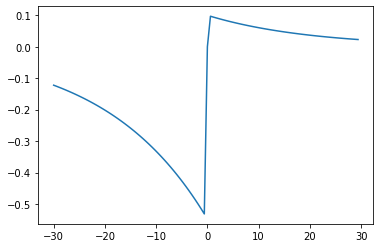

In [7]:
# defino un vector de pesos
w = torch.ones(100) * 1

# defino vector de tiempos
extremo = 60 #mseg
dt = (torch.tensor(range(len(w))) - len(w)/2)/(len(w/2)) * extremo

out = deltaw_Morr(dt,w)

plt.plot(dt.numpy(), out.numpy())
plt.show()


# Modelo STDP correspondiente al Estriado

## Sinapsis cortico estriatal

Fino et all 2005 estudiaron la interacción entre neuronas del layer V de la corteza somatosensorial y las neuronas espinosas estriatales (via directa me parece, pero en este paper no importaria). En este paper no consideran un tercer factor, es decir neurotransmisores que modulan el aprendizaje, como la dopamina y acetilcolina. Determinan que estimulación con pulsos de alta frecuencia (HFS) imponen procesos LTP, principalmente por mecanismos pre-sinapticos. Por otro lado, la estimulación en baja frecuencia (LFS) produce LTD a partir de procesos postsinápticos. 

### Reversed STDP

En otro experimento evocan un potencial de acción (AP) en la neurona estriatal, y aplican un corriente depolarizante supraumbral en la neurona cortical, se plantean dos situaciones:
- **pre-post**: la corriente depolarizante se aplica previo al potencial de acción. Esta situación plantea la situación donde la actividad pre-sinaptica evoca un AP en la post-sinapsis.
- **post-pre**: en este caso, la actividad post sinaptica, es decir el AP, ocurre primero. Busca simular el caso donde la actividad pre-sinaptica no está participando en la generación del AP post sináptico. 

La siguiente figura muestra los resultados de este experimento.
<img src="img/fino_2005.png" alt="drawing" width="500"/> 

Es interesante notar que el STPD está invertido. Es decir, la actividad **pre-post** plantea un aprendizaje **LTD**, mientras que **post-pre** plantea un aprendizaje **LTP**. 

Este descubrimiento fue muy interesante, por una parte porque encuentra un modelo STDP anti-Hebbiano en una estructura importante como es el estriado. Pero también plantea una estructura donde la información que no evoca un AP es relevante para la estructura. Esto puede significar que el estriado ¨busca¨ relacionar información temporal, ya que esa información presinaptica, que no activa la neurona, lo hará en un futuro, ya que se potencia mediante LTP, y todo en una ventana de $\pm 30 mseg$.

Este paper no considera terceros factores.

### Aproximación a un modelo de STDP para neuronas estriatales.

Se va a partir de los datos medidos por Fino et al 2005 (figura superior), los cuales se transcriben en el siguiente vector:        





In [19]:
from scipy.stats import norm
from itertools import product

In [15]:
def fgauss(x,loc=0,scale=1):
    # Son las funciones de la base del espacio del estimador.
    # scale es equivalente a varianza
    funcion = norm(loc=loc, scale=scale)
    return funcion.pdf(x)

def f_detalle(x, parameters, flag=None ):
    w = parameters[0]
    media = parameters[1]
    loc_vect = parameters[2]
    sigma = parameters[3]
    out = np.zeros(x.shape)
    if flag==None:
        for i in range(len(w)):
            out = w[i] * fgauss(x,loc=loc_vect[i], scale=sigma ** 2) + out
        return out + 1
    else:
        out = w[flag] * fgauss(x,loc=loc_vect[flag][0], scale=sigma ** 2) 
        return out + 1

def estimador(x,y,M, alpha):
    max_t = max(x)
    min_t = min(x)
    sigma = (max_t - min_t)/M/alpha # SD de las gaussianas => solapa con el 31.8% del área a las otras.
    loc_vect = np.asarray([i * (max_t-min_t)/M + (min_t + (max_t-min_t)/2/M) for i in range(M)])
    media = np.mean(y)
    y = y - media
    Q = np.zeros((len(x),M))
    Q = np.zeros((len(x),M))
    for i in range(M):
        Q[:,i] = fgauss(x,loc=loc_vect[i], scale=sigma ** 2)[:,0]
        
    Q_pinv = np.linalg.pinv(Q)
    w = np.matmul(Q_pinv, y)
    # Calculo de metrica de AKAIKE
    y_est = f_detalle(x, (w, media, loc_vect, sigma))
    aic = 2*M + len(x)* np.log(2*np.pi*sigma**2)+1/(sigma ** 2) * (np.linalg.norm(y-y_est)**2)
    return (w, media, loc_vect, sigma, aic)



In [13]:
# Se considera la gráfica anterior (Fino et al 2005)

delta_t = np.asarray([-40, -35.8, -30, -30, -22.96, -22.13, -19.89, -18.96, -12.78, -11.79, -7.95,
          -19.9, -14.96, -9.09, -7.01, 0, 0, 0, 0,  4.94, 12.94, 14.96, 17.04, 18.96,
          18.96, 20.05, 23.89, 24.99, 27.90, 30, 30, 30.91, 36.94])
y_stdp = np.asarray([110, 88.4, 100, 100, 139.2, 104.61, 98.8, 115.76, 108.85, 92.69, 118.08,
         253.08, 251.15, 200.38, 246.15, 100, 100, 100, 100, 115, 76.15, 25.38, 26.54, 56.92,
         76.92, 95.38, 74.84, 47.30, 74.61, 100, 100, 116.92, 104.6])
y_stdp = y_stdp/100
delta_t = delta_t.reshape(len(delta_t),1)
y_stdp = y_stdp.reshape(len(y_stdp),1)


In [37]:
MM_range = range(3,11)
aa_range = range(3,9)
resultado = []
for k in product(MM_range,aa_range):
    aux = [k[0], k[1], estimador(delta_t, y_stdp, M=k[0], alpha = k[1])[4][0] ]
    resultado.append(aux)
resultado = np.asarray(resultado)
# minimo akaike
resultado[resultado[:,2]==min(resultado[:,2]),:]

array([[  9.        ,   8.        , 116.15307559]])

[[-0.60889911]
 [-5.64807325]
 [ 1.48413225]
 [ 2.89217537]
 [-0.6761207 ]
 [ 0.80642175]
 [-3.4023819 ]
 [-1.52314147]
 [ 0.26861279]]
1.0962757575757576


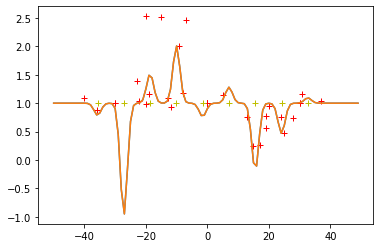

In [38]:
MM = 9 #4 5 5 6 6 
aa = 8 #6 4 5 5 4

parameters = estimador(delta_t, y_stdp, M=MM, alpha = aa)
print(parameters[0])
print(parameters[1])

rango = np.asarray(range(100))-50
salida = f_detalle(rango, parameters)
plt.plot(rango, salida)
plt.plot(delta_t,y_stdp, 'r+')
plt.plot(parameters[2], np.zeros((len(parameters[2]),1))+1, 'y+')
#for i in range(MM):
#    plt.plot(rango, f_detalle(rango, parameters, flag=i), 'k')
plt.plot(rango, salida)

Como se ve, Akaike produce overfitting. No nos sirve como criterio.

In [17]:
parameters[4]

array([153.23420058])

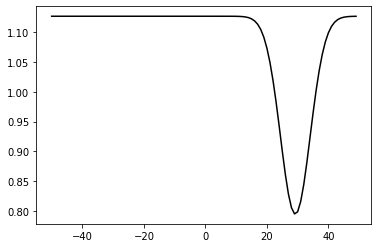

In [66]:
plt.plot(rango, f_detalle(rango, parameters, flag=1), 'k')

In [56]:
loc_vect = parameters[2]

In [67]:
loc_vect

array([[-32.306],
       [-16.918],
       [ -1.53 ],
       [ 13.858],
       [ 29.246]])

In [70]:
None == None

True

In [4]:
def deltaw_ctx_spn(deltat,w):
    # constantes
    mu = 0.4
    tau = 20.0  # ms
    w0 = 1.0  # pA
    lamb = 0.1
    alpha = 5.478 # originalmente estaba en 0.11, pero no daba con una reducción de 40% a -6.3msg
    
    out = torch.zeros(len(deltat))
    aux = torch.exp(-torch.abs(deltat)/tau)
    out = lamb * (w0 ** (1 - mu)) * (w ** mu) * aux * ((deltat < 0)*1.0)
    out = -lamb * alpha * w * aux * ((deltat > 0) * 1.0)
    return out

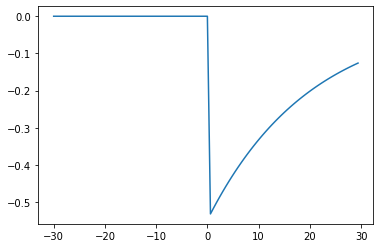

In [5]:
# defino un vector de pesos
w = torch.ones(100) * 1

# defino vector de tiempos
extremo = 60 #mseg
dt = (torch.tensor(range(len(w))) - len(w)/2)/(len(w/2)) * extremo

out = deltaw_ctx_spn(dt,w)

plt.plot(dt.numpy(), out.numpy())
plt.show()

In [50]:
out[torch.logical_and(dt<-6,dt>-7) ]


tensor([-0.0079])

In [17]:
a=(torch.randn(10)>0)*5
len(a)

10

In [15]:
torch.exp(torch.tensor([1.]))


tensor([2.7183])

In [29]:
((torch.zeros(10)+2)**2) * (torch.zeros(10)+2)

tensor([8., 8., 8., 8., 8., 8., 8., 8., 8., 8.])

In [60]:
lamb * (w0 ** (1 - mu)) * (w ** mu)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])